## 商品期货套利策略的研究报告
### ——基于ricequant平台数据及回测引擎的DEMO

套利策略是交易合约对之间的价差的策略，基于期待价差有均值回归效应的一种策略类型，本质上还是对波动率的预测。

除了某些如固收、期现套利的策略外，目前常见的套利策略是基于行情数据的时间序列进行建模和预测的统计套利，因此研究思路与cta的反趋势类策略思路有类似的地方。

统计套利由于其合约对在对冲后风险可控的特征，往往其回报率也是可预测的，因此与量化能有很好的结合，是量化研究不可或缺的一个方向。

从合约对的角度来看，套利策略一般分为跨期和跨品种两类策略，本报告基于个人见解和同行的交流、专家教导，给出一种跨期套利策略的研究过程，望能获得充分批评，继续改进策略研究过程和效率。

### 策略研究流程

作为量化的初学者，我认为统计套利量化研究的过程可以分为下面几个步骤：

1、准备数据，建立数据库————————自建、第三方（wind、ts等来源）

        |
        V
2、开发回测引擎————————————自建、第三方（安全性、灵活性以及效率）

        |
        V
3、找出可套利合约对——————————利用相关性、OLS检验、adf检验等方法

        |
        V
4、策略雏形、框架、想法————————来源于经验、交流、书籍论文等

        |
        V   
5、准备样本——————————————需要验证的行情数据，与统计方法的train set/test test思路类似，分为回测样本、验证样本

        |
        V
6、确定策略总体思路和模型框架—————确定模型、参数、品种、周期等，进行初步统计检验

        |
        V
7、基于回测引擎开发单个策略——————交易报单、日志与行情比对，需要反复确认买卖逻辑等是否符合策略思想、交易规则
        
        |
        V
8、在回测样本上回测、训练参数—————确认需要训练的参数、步长等
        
        |
        V
9、分析回测结果————————————绩效指标（sharpe、maxdrawdown等）以及参数的分析、统计检验，避免过拟合
        
        |
        V
10、回测验证样本————————————分析策略的可行性，若有过拟合的犹豫，重复7-9，或者回到3、4，改进策略逻辑，测试其他品种等。
        
        |
        V
11、基于研究的模拟交易，进行一段时间观察————模拟交易环境要与实盘交易环境一致
        
        |
        V
12、重复3-11，研究、开发一系列策略、推送实盘（如何做投资组合可以展开为其他量化思路了）

关于引擎、系统开发，个人对这一块还不太熟，研究报告基于ricequant平台去进行步骤4-9的研究。

### 策略雏形、框架、想法

套利是对价差的交易，而可套利合约对的价差一般是一个平稳的时间序列，因此本质上是在做空价差的波动率。

波动率函数有很多种计算方法，比如常用的收益率标准差除以样本数平方根，均价的标准差区间如布林带指标，基于最高价减去最低价构成的range如经典的ATR指标等。

布林带由于有上下轨，因此对要实现多空的均值回归策略来说是一个简单有效的指标。

目前策略初步想法是价差向上突破mean + n2 x std后准备做空，当回归至mean + n1 x std后进场，其中n1 < n2。

以国内商品期货市场为例，螺纹钢由于成交量较大，对套利策略是一个不错的研究品种，当然如RB/HC等跨品种套利也是可行的（可以使用statsmodels.tsa.stattools.coint找出有协整关系的合约对），不过为了简化回测过程（合约对的手数比例1:1可以简化FAK等撮合逻辑），这里选择螺纹钢的主合约和次合约进行跨期套利进行示例。

首先，考察螺纹钢的交易规则，螺纹钢在14年12月26日才开始出夜盘，而在16年5月3日则把夜盘改为2小时。

当然最好选取与现在有统一规则的区间作为样本，夜盘的时间会直接影响套利策略的交易次数从而使过往的预测模型效能下降。

其次是保证金比例的调整，过往螺纹钢的保证金比例是5%~7%，每20000人民币至少可以做2X4手套利合约，而17年后主力合约在接近交割月时保证金比例会上升到20%，每20000元只能做2X1手套利合约，对套利策略是一个不少的打击。

不过好在主合约和次合约的交易时间是对齐的，这一点无需担心。

### 准备样本

在准备回测的合约对时，螺纹钢的主力合约是1/5/10月，其中5~10月之间的间隔颇大，在这个时间段的早期，其次合约的流动性可能会有问题。不过为了回测见过的连续性，这里准备的合约对是时间连续的。

这里选择了1分钟K线的收盘价作为套利的两腿。

需要说明的是，在做检验时，选取了生成的合约对中2012-09-26至2018-04-25的5年连续数据作为检验样本。

不过在回测策略中，回测的样本是2015-05-04至2017-04-28，测试的样本是2017-05-02至2017-05-11。

In [1]:
import os

import numpy as np
import pandas as pd
import talib as ta                  
import math  

from datetime import datetime,timedelta
import statsmodels.api as sm      
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)   #设置画板大小
import matplotlib.pyplot as plt

In [2]:
# 获得单一品种的合约symbol和时间, delta_days是从leg1合约结束前的n天
# range_days是每个合约时间跨度，可用于统一时间跨度的比较，如果为None，则合约结束时间与下个合约开始时间连续，可组成连续合约
def generate_contracts_1(leg1_list, delta_days = 20, range_days = None):
    
    contracts = []
    # 根据第一个合约信息录入第一个合约对，再迭代出其他合约对
    ins = instruments(leg1_list[0])
    # 获得交割日期
    pre_maturity_date = datetime.strptime(ins.maturity_date,'%Y-%m-%d')
    if range_days == None:
        pre_start_date = pre_maturity_date - timedelta(days = 111)
    else:
        pre_start_date = pre_maturity_date - timedelta(days = delta_days + range_days)
    pre_end_date  = pre_maturity_date - timedelta(days = delta_days)
    
    print('{0},{1},{2},{3}'.format(leg1_list[0],leg1_list[1],pre_start_date.strftime('%Y-%m-%d'),pre_end_date.strftime('%Y-%m-%d')))
    contracts.append({
        'leg1' : leg1_list[0],
        'leg2' : leg1_list[1],
        'start_date' :  pre_start_date.strftime('%Y-%m-%d'),
        'end_date' : pre_end_date.strftime('%Y-%m-%d')
      })
    
    for i in range(1, len(leg1_list)-1):
      
        leg1 = leg1_list[i]
        leg2 = leg1_list[i+1]
        ins  = instruments(leg1)

        maturity_date = datetime.strptime(ins.maturity_date,'%Y-%m-%d')
        # range_days为None，则生成时间连续合约对，否则生成统一时间长度合约对
        if range_days == None:
            start_date = pre_end_date + timedelta(days = 1)
        else:
            start_date = maturity_date - timedelta(days = delta_days + range_days)
        end_date = maturity_date - timedelta(days = delta_days)
        pre_end_date  = end_date

        contract = {}

        contract['leg1'] =leg1
        contract['leg2'] = leg2
        contract['start_date'] = start_date.strftime('%Y-%m-%d')
        contract['end_date']   = end_date.strftime('%Y-%m-%d')

        contracts.append(contract)

        print ('{0},{1},{2},{3}'.format(leg1,leg2,start_date.strftime('%Y-%m-%d'),end_date.strftime('%Y-%m-%d')))
        
    return contracts

In [3]:
# 13年至18年的所有合约对
leg1_list = []

for y in range(13,19):
    for m in [1,5,10]:
        leg1_list.append('RB{}{:02}'.format(y, m))

In [4]:
contracts = generate_contracts_1(leg1_list = leg1_list, delta_days = 20, range_days = None)

df = pd.DataFrame(contracts) 
df.to_csv('RB_contracts.csv')

RB1301,RB1305,2012-09-26,2012-12-26
RB1305,RB1310,2012-12-27,2013-04-25
RB1310,RB1401,2013-04-26,2013-09-25
RB1401,RB1405,2013-09-26,2013-12-26
RB1405,RB1410,2013-12-27,2014-04-25
RB1410,RB1501,2014-04-26,2014-09-25
RB1501,RB1505,2014-09-26,2014-12-26
RB1505,RB1510,2014-12-27,2015-04-25
RB1510,RB1601,2015-04-26,2015-09-25
RB1601,RB1605,2015-09-26,2015-12-26
RB1605,RB1610,2015-12-27,2016-04-26
RB1610,RB1701,2016-04-27,2016-09-27
RB1701,RB1705,2016-09-28,2016-12-27
RB1705,RB1710,2016-12-28,2017-04-25
RB1710,RB1801,2017-04-26,2017-09-26
RB1801,RB1805,2017-09-27,2017-12-26
RB1805,RB1810,2017-12-27,2018-04-25


In [5]:
# 读取2个合约的分钟收盘价数据
def get_df(leg1_symbol, leg2_symbol, start_date, end_date, freq):
    
    leg1 = get_price(leg1_symbol, start_date=start_date, end_date=end_date, fields='close', frequency=freq)  # leg1
    leg2 = get_price(leg2_symbol, start_date=start_date, end_date=end_date, fields='close', frequency=freq)  # leg2

    # 创建DataFrame，合并Leg1，Leg2
    df = leg1.to_frame(name='leg1')
    df['leg2'] = leg2
    return df

In [6]:
# 生成csv文件
def generate_data(df, freq = '1m'):

    for index, row in df.iterrows():
        leg1_symbol = row['leg1']
        leg2_symbol = row['leg2']
        start_date  = row['start_date']
        end_date    = row['end_date']
        try:
            df = get_df(leg1_symbol, leg2_symbol, start_date, end_date, freq)
        except:
            pass
          
        folder_name = 'rb_pairs_{}'.format(freq)
        file_name = '{}_{}_{}_{}_{}.csv'.format(leg1_symbol, leg2_symbol, start_date, end_date, freq)
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        df.to_csv('{}/{}'.format(folder_name, file_name))

In [7]:
# 生成1min文件
generate_data(df)

In [8]:
# 读取单个合约对文件
def read_df(filename, datetimeindex = False):
    df = pd.read_csv(filename)
    columns = df.columns.tolist()
    columns[0] = 'datetime'
    df.columns = columns
    df = df.set_index('datetime', drop = False)
    if datetimeindex:
        df.index = pd.DatetimeIndex(df.index)
    df = calculate(df)
    
    return df

In [9]:
# 合成连续数据
def concat_df(df, datetimeindex = False):
    leg1_symbol = df.ix[0]['leg1']
    leg2_symbol = df.ix[0]['leg2']
    start_date  = df.ix[0]['start_date']
    end_date    = df.ix[0]['end_date']
    freq        = '1m'

    file_name = 'rb_pairs_1m/{}_{}_{}_{}_{}.csv'.format(leg1_symbol, leg2_symbol, start_date, end_date, freq)
    df_test = pd.read_csv(file_name)

    for index in range(1,len(df)):
        leg1_symbol = df.ix[index]['leg1']
        leg2_symbol = df.ix[index]['leg2']
        start_date  = df.ix[index]['start_date']
        end_date    = df.ix[index]['end_date']
        freq        = '1m'

        file_name = 'rb_pairs_1m/{}_{}_{}_{}_{}.csv'.format(leg1_symbol, leg2_symbol, start_date, end_date, freq)
        df2 = pd.read_csv(file_name)

        df_test = pd.concat([df_test, df2], axis=0)
        
    columns = df_test.columns.tolist()
    columns[0] = 'datetime'
    df_test.columns = columns
    df_test = df_test.set_index('datetime', drop = False)    
    # index设为datetime类型
    if datetimeindex:  
        df_test.index = pd.DatetimeIndex(df_test.index)
        
    return df_test

这里我选择了把所有合约对合成一个df，也可以每个合约对分开检验和测试，有利有弊。

合成的好处是在进行优化参数可以获得更solid和robust的结论，策略的泛化能力和抗风险能力可能会有所提升。

不过交易规则变动以及特殊时期的特殊行情可能会使每个时期的波动规律可能会使序列出线不太平稳的状况，对近期行情的预测力也会有所下降。

分开的话则需要用上一个合约对来预测本合约对，能拟合出更好的回报率，但可靠性可能会下降，更适用于对参数自适应的策略，比如网格。

In [10]:
df_test = concat_df(df,True)

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442080 entries, 2012-09-26 09:01:00 to 2018-04-25 15:00:00
Data columns (total 3 columns):
datetime    442080 non-null object
leg1        442080 non-null float64
leg2        442080 non-null float64
dtypes: float64(2), object(1)
memory usage: 13.5+ MB


### 确定策略总体思路和模型框架

In [12]:
# 计算各种指标
def calculate(df, period = 20, n_std = 2.0):
    # 计算leg1 - leg2
    df['diff'] = df.leg1 - df.leg2
    # 计算价差布林带
    df['boll_up'],df['boll_mid'],df['boll_low'] = ta.BBANDS(df['diff'].values,
                                                            timeperiod = period, nbdevup = n_std, nbdevdn = n_std)
    
    # 计算leg1/leg2
    df['ratio'] = df.leg1 / df.leg2
    # 计算ratio的ma
    df['ma_ratio'] = df['ratio'].rolling(window = period, center = False).mean()
    # 计算按照ma_ratio结果的预期leg2值
    df['ma_mean']= df.leg1 / df.ma_ratio 
    # 计算残差
    df['ma_diff_leg2'] = df.ma_mean - df.leg2
    # 计算残差布林带
    df['ma_boll_up'],df['ma_boll_mid'],df['ma_boll_low'] = ta.BBANDS(df['ma_diff_leg2'].values,
                                                                     timeperiod = period, nbdevup = n_std, nbdevdn = n_std)
    return df

In [13]:
# OHLC的指标计算
def calculate2(df, period = 20, n_std = 2.0):
    # 计算range
    df['range'] = df['high'] - df['low']
    # 计算滚动标准差
    df['std'] = df['close'].rolling(window = period, center = False).std()
    df['-std'] = -1 * df['std']
    # 计算价差布林带
    df['boll_up'],df['boll_mid'],df['boll_low'] = ta.BBANDS(df['close'].values,
                                                            timeperiod = period, nbdevup = n_std, nbdevdn = n_std)    
    # 计算ma
    df['ma'] = df['close'].rolling(window = period, center = False).mean()
    # 计算ma和close的残差
    df['ma_diff'] = df['ma'] - df['close']
    # 计算残差布林带
    df['ma_boll_up'],df['ma_boll_mid'],df['ma_boll_low'] = ta.BBANDS(df['ma_diff'].values,
                                                            timeperiod = period, nbdevup = n_std, nbdevdn = n_std)
    # 残差偏离标准差的z值
    df['zscore'] = df['ma_diff'] / df['std']
    # 计算回报率
    df['return'] = df['close'].diff(1) / df['close']
    
    return df

In [14]:
# ols检验，比率均价的展示
def display_ols(df, leg1, leg2, n_std=2, constant = False):
    columns = []
    columns.append(leg1)
    columns.append(leg2)   
    df2 = df[columns]
    y = df2[leg1].values
    x = df2[leg2].values
    X = sm.add_constant(x)
    if constant:
        model = sm.OLS(y,X)
        result = model.fit()
    else:
        model = sm.OLS(y,x)
        result = model.fit()
    print(result.summary())        
    
    # 查看两个合约的配比
    plt.figure(figsize=[16,10])
    (df2[leg1]/df2[leg2]).plot(label = 'leg1/leg2') # 查看 leg1/leg2的价格比率
    plt.axhline(np.mean(y/x), color="red", linestyle="-.", label = 'mean')
    plt.axhline(np.mean(y/x) + np.std(y/x)*n_std, color="red", linestyle="--", label = 'mean + {}*std'.format(n_std))
    plt.axhline(np.mean(y/x) - np.std(y/x)*n_std, color="red", linestyle="--", label = 'mean - {}*std'.format(n_std))
    
    plt.legend()
    plt.show()
    
    return result

In [15]:
# 单y轴画图
def display1(df, columns):
     # 设置画布大小
    matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
    
    # 获取需要显示得数据行
    df2 = df[columns]    
    
    fig, ax1 = plt.subplots()
    
    df2.index = list(range(len(df2)))
    for column in columns:
        ax1.plot(df2[column], label = column)
    
    # 修改x轴的label为时间
    xt = ax1.get_xticks()   
    xt2 = [df.index[int(i)]  for i in xt[1:-2]]
    xt2.insert(0,'')
    xt2.append('')    
    ax1.set_xticklabels(xt2)    
    
    plt.legend()
    plt.show()

In [16]:
# 双y轴画图
def display2(df, columns1, columns2=[]):
    # 设置画布大小
    matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
    
    df1 = df[columns1]
    df1.index = list(range(len(df)))

    fig, ax1 = plt.subplots()

    ax1.plot(df1)
    
    if len(columns2) > 0:
        df2 = df[columns2]
        df2.index = list(range(len(df)))
        ax2 = ax1.twinx()        
        ax2.plot(df2)
        
    plt.grid()
    
    # 修改x轴的label为时间
    xt = ax1.get_xticks()    
    xt2 = [df.index[int(i)]  for i in xt[1:-2]]
    xt2.insert(0,'')
    xt2.append('')
    ax1.set_xticklabels(xt2)
    
    plt.legend()
    plt.show()

In [17]:
df_test[['leg1', 'leg2']].corr('spearman')

,leg1,leg2
leg1,1.000000,0.985757
leg2,0.985757,1.000000


两腿的相关性很高，这是组成合约对的关键。

In [18]:
df_test = calculate(df_test)

In [19]:
df_test[40:45]

,datetime,leg1,leg2,diff,boll_up,boll_mid,boll_low,ratio,ma_ratio,ma_mean,ma_diff_leg2,ma_boll_up,ma_boll_mid,ma_boll_low
datetime,,,,,,,,,,,,,,
2012-09-26 09:41:00,2012-09-26 09:41:00,3564.0,3618.0,-54.0,-48.546971,-51.85,-55.153029,0.985075,0.985655,3615.870053,-2.129947,-0.908755,-2.896931,-4.885108
2012-09-26 09:42:00,2012-09-26 09:42:00,3564.0,3617.0,-53.0,-48.775097,-52.00,-55.224903,0.985347,0.985615,3616.015870,-0.984130,-0.636974,-2.776736,-4.916499
2012-09-26 09:43:00,2012-09-26 09:43:00,3562.0,3615.0,-53.0,-49.033913,-52.15,-55.266087,0.985339,0.985575,3614.133913,-0.866087,-0.375636,-2.657634,-4.939632
2012-09-26 09:44:00,2012-09-26 09:44:00,3564.0,3617.0,-53.0,-49.326786,-52.30,-55.273214,0.985347,0.985536,3616.306909,-0.693091,-0.112264,-2.540024,-4.967785
2012-09-26 09:45:00,2012-09-26 09:45:00,3567.0,3620.0,-53.0,-50.316169,-52.55,-54.783831,0.985359,0.985469,3619.597835,-0.402165,0.000203,-2.511781,-5.023764


leg1 - leg2的价差图形，可以看出序列的平稳性较差，无法使用简单的mean进行回归

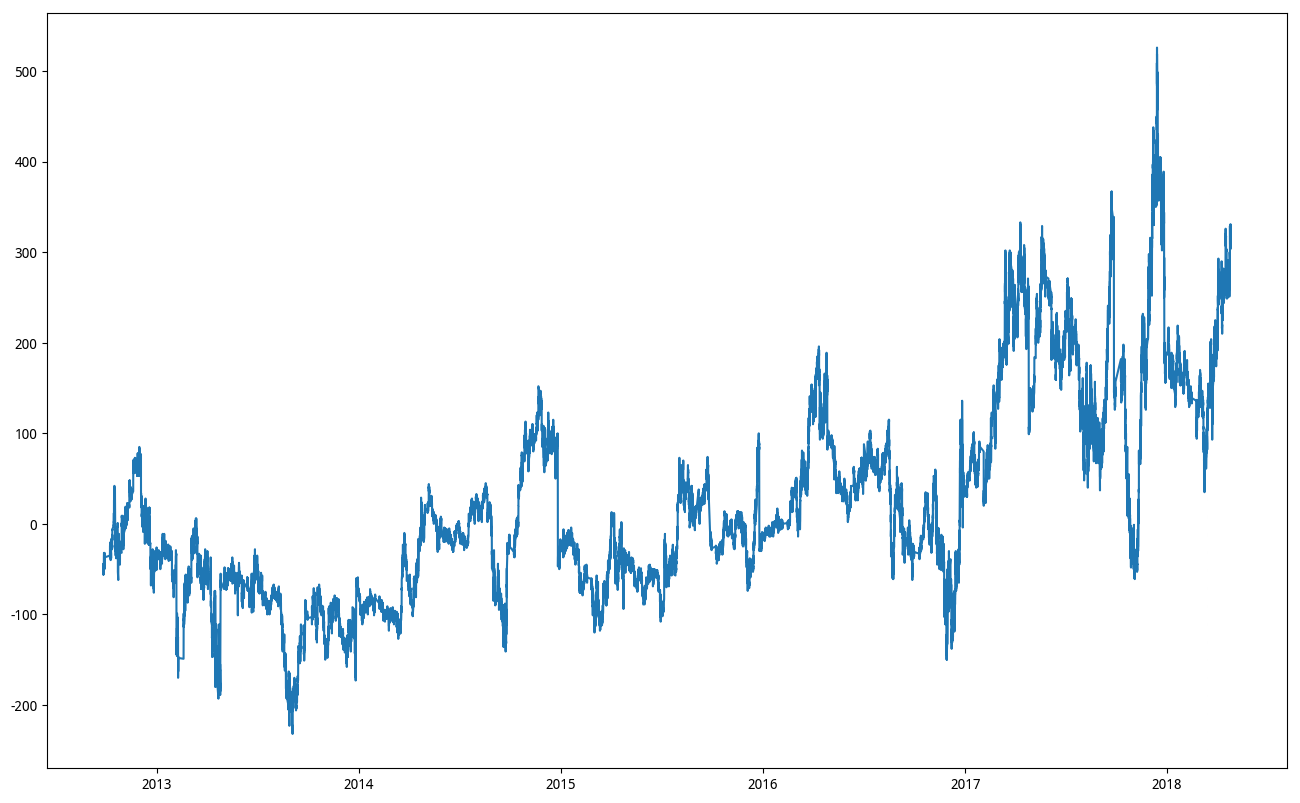

In [20]:
plt.plot(df_test['diff'])
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.918e+07
Date:                Thu, 24 May 2018   Prob (F-statistic):               0.00
Time:                        02:37:55   Log-Likelihood:            -2.7046e+06
No. Observations:              442080   AIC:                         5.409e+06
Df Residuals:                  442078   BIC:                         5.409e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.8297      0.688    -47.714      0.0

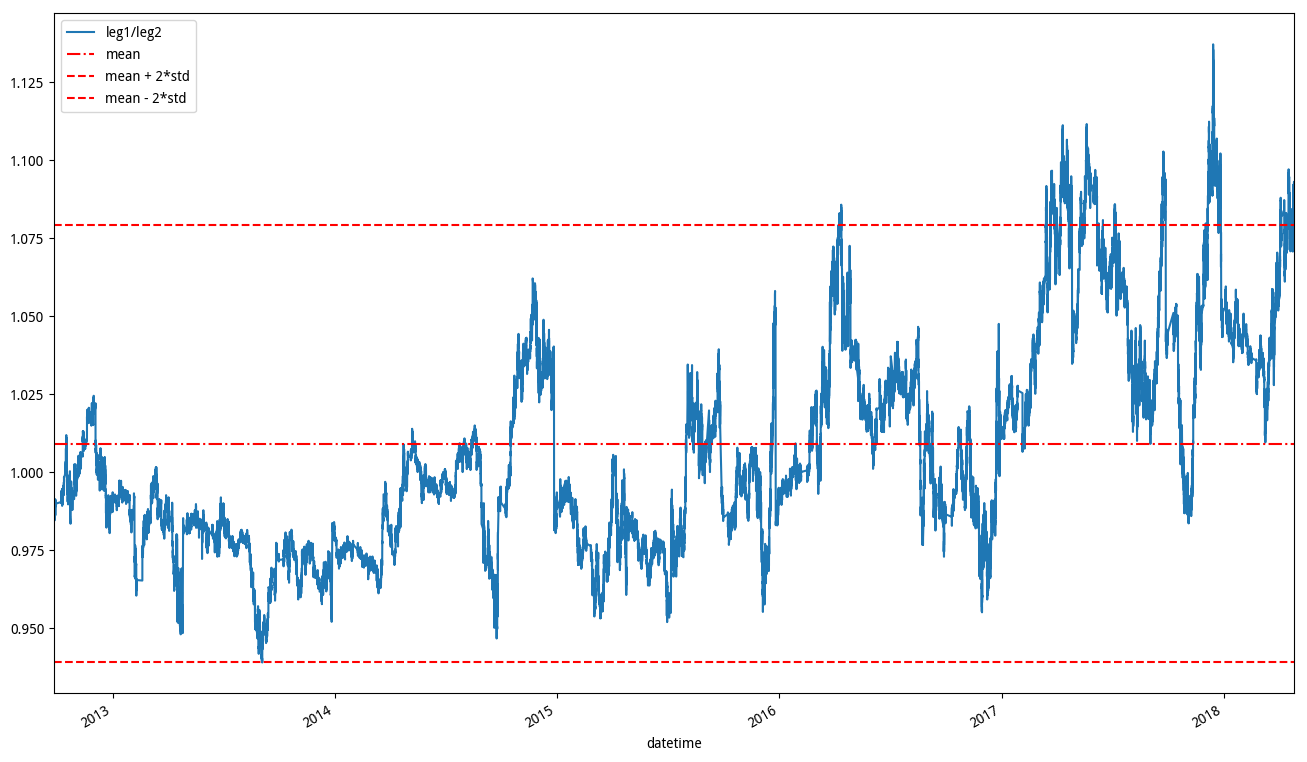

In [21]:
display_ols(df_test, 'leg1', 'leg2', 2, constant = True)

对全时期的OLS检验的结果，可以看出条件数很大，会放大预测的误差，因此这个线性拟合公式（leg1 = leg2 * 1.0215 - 32.8297）不太可靠。

再看看一个合约对时期内的OLS检验

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.546e+08
Date:                Thu, 24 May 2018   Prob (F-statistic):               0.00
Time:                        02:38:21   Log-Likelihood:            -1.8073e+05
No. Observations:               36225   AIC:                         3.615e+05
Df Residuals:                   36224   BIC:                         3.615e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0189   8.19e-05   1.24e+04      0.0

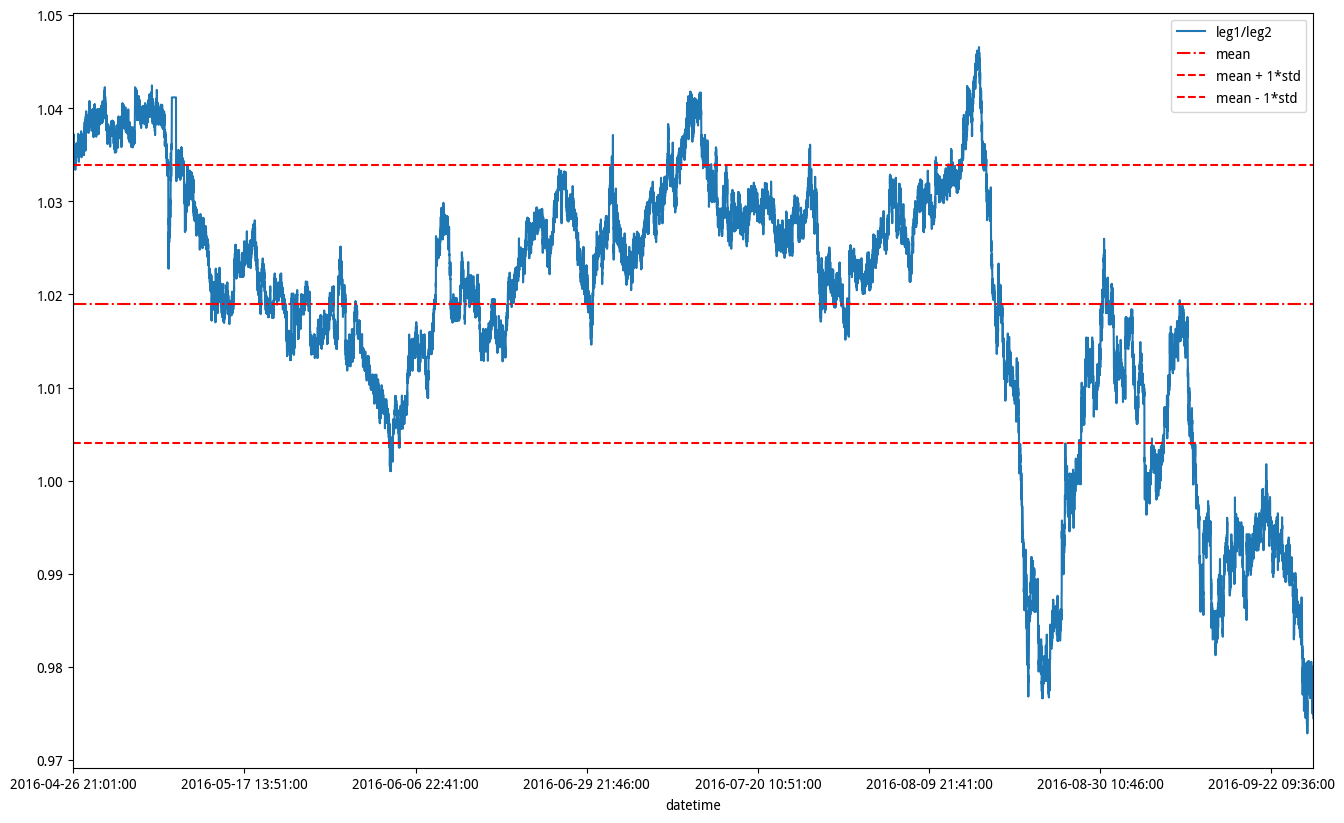

In [22]:
df2 = read_df('rb_pairs_1m/RB1610_RB1701_2016-04-27_2016-09-27_1m.csv')
display_ols(df2, 'leg1', 'leg2', 1)

从侧面说明了使用mean作为均值的可套利空间并不多，使用ma会更好。

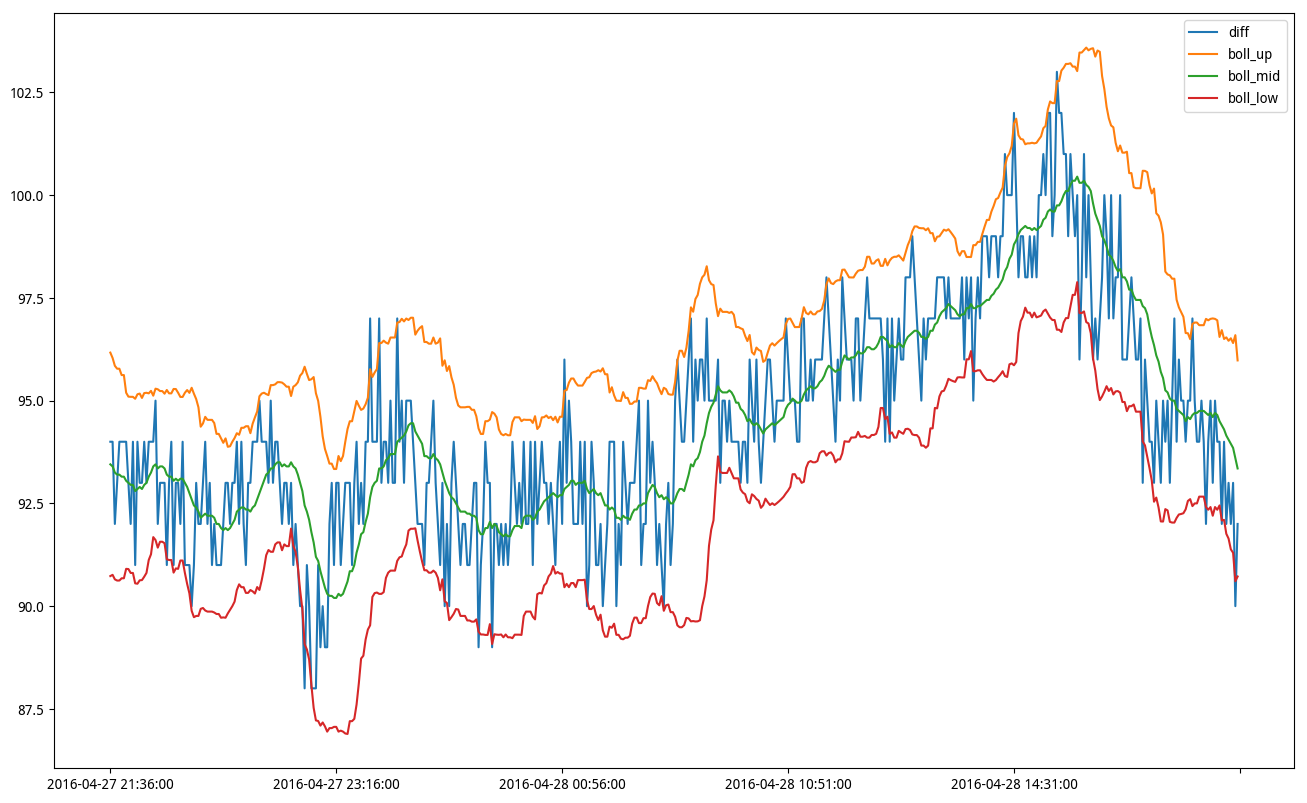

In [23]:
display1(df2[500:1000], ['diff','boll_up','boll_mid','boll_low'])

价差和价差的布林带的一个片段，逐个分析的话，会发现1分钟的序列对默认参数（ma=20，std=2）的可套利空间并不大。

因为leg1和leg2的价格比例接近1:1，因此这里选择了价差作为套利

不过也可以看看leg1/leg2的残差和残差的布林带，因为费用的问题，残差的套利空间可能不会太大，需要另外验证。

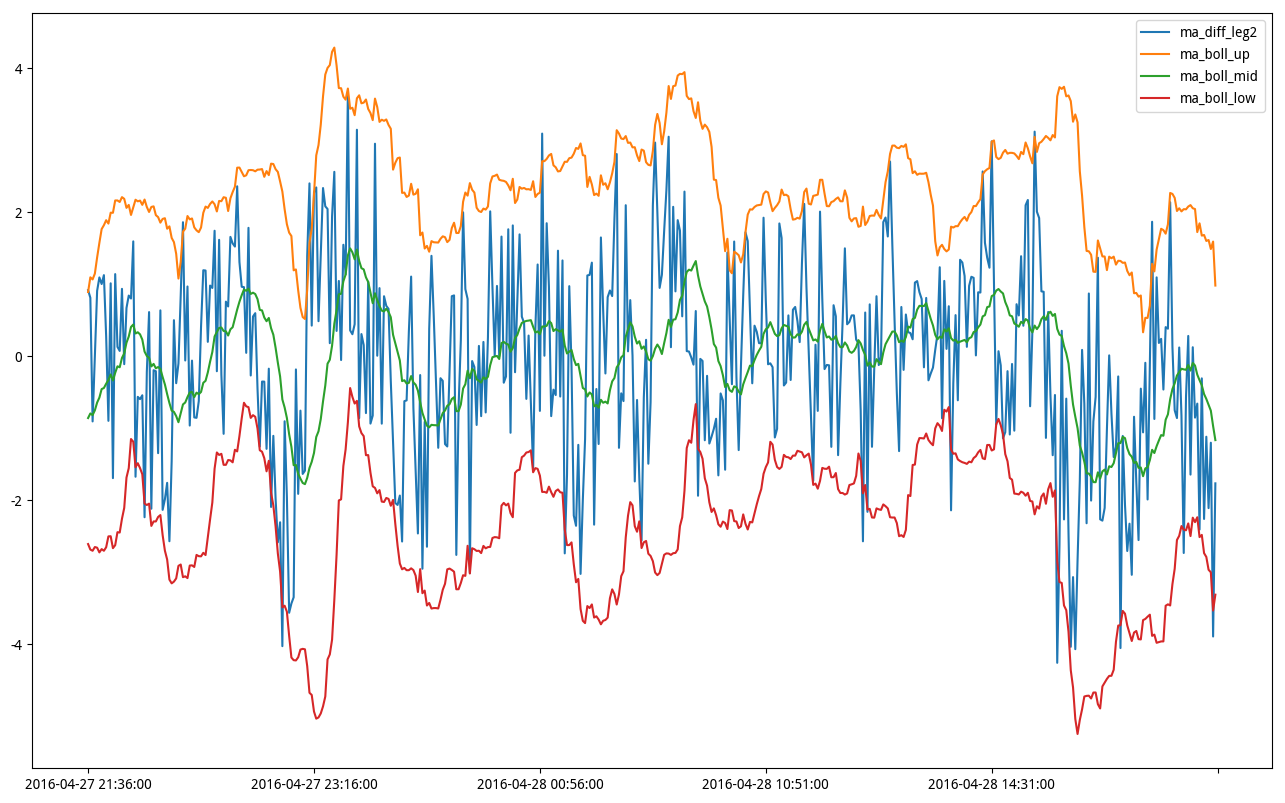

In [24]:
display1(df2[500:1000], ['ma_diff_leg2','ma_boll_up','ma_boll_mid','ma_boll_low'])

1分钟的套利空间可能不大，而且验证时间也很长，因此下面来看看5分钟的，这里利用1分钟diff合成5分钟K线

In [25]:
df_m5 = df_test['diff'].resample('5Min').ohlc().dropna()

In [26]:
df_m5 = calculate2(df_m5)

In [27]:
df_m5[40:45]

,open,high,low,close,range,std,-std,boll_up,boll_mid,boll_low,ma,ma_diff,ma_boll_up,ma_boll_mid,ma_boll_low,return
datetime,,,,,,,,,,,,,,,,
2012-09-26 14:25:00,-50.0,-50.0,-52.0,-52.0,2.0,1.517442,-1.517442,-47.791960,-50.75,-53.708040,-50.75,1.25,2.551595,-0.5450,-3.641595,0.019231
2012-09-26 14:30:00,-51.0,-49.0,-52.0,-49.0,3.0,1.517442,-1.517442,-47.791960,-50.75,-53.708040,-50.75,-1.75,2.502076,-0.5025,-3.507076,-0.061224
2012-09-26 14:35:00,-50.0,-49.0,-51.0,-51.0,2.0,1.507874,-1.507874,-47.860612,-50.80,-53.739388,-50.80,0.20,2.555451,-0.4025,-3.360451,0.039216
2012-09-26 14:40:00,-52.0,-52.0,-54.0,-52.0,2.0,1.507874,-1.507874,-47.860612,-50.80,-53.739388,-50.80,1.20,2.693332,-0.3425,-3.378332,0.019231
2012-09-26 14:45:00,-53.0,-53.0,-55.0,-55.0,2.0,1.713722,-1.713722,-47.559341,-50.90,-54.240659,-50.90,4.10,3.393989,-0.1800,-3.753989,0.054545


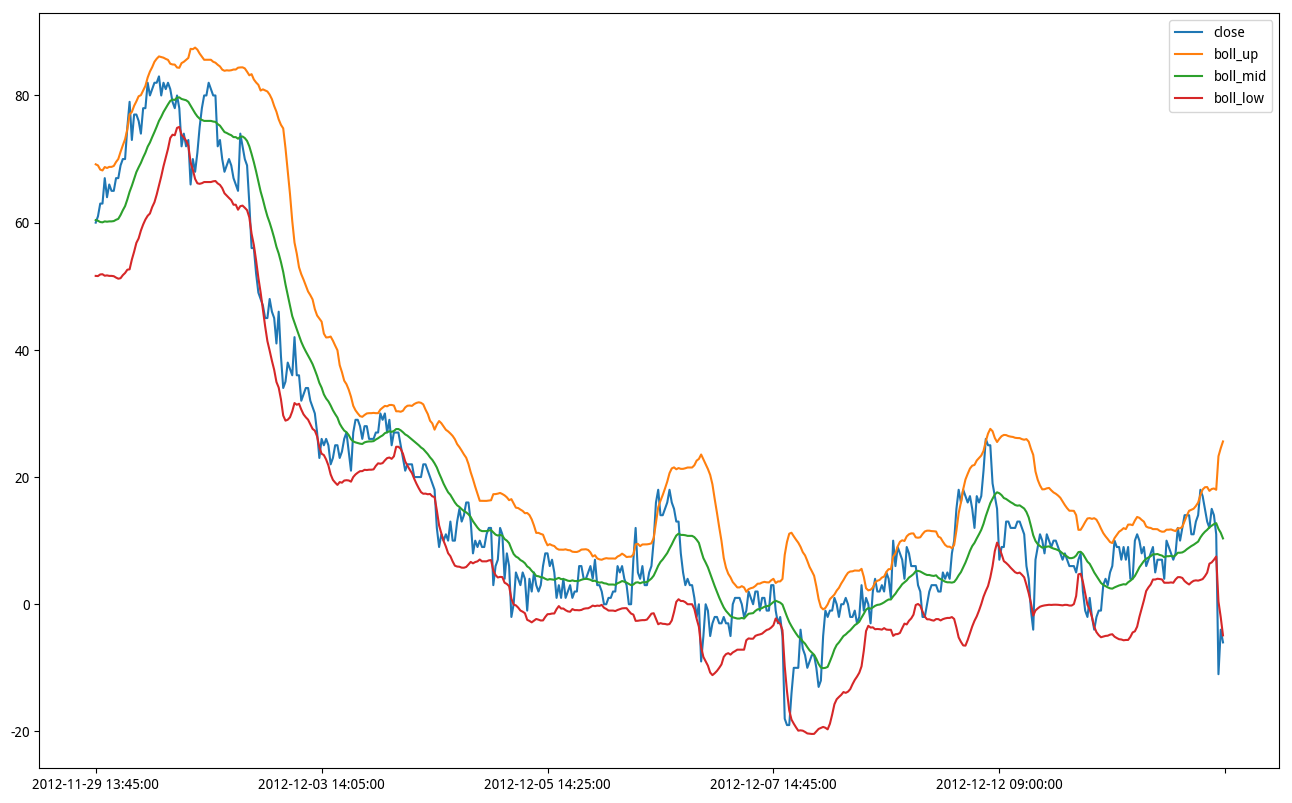

In [28]:
display1(df_m5[2000:2500], ['close','boll_up','boll_mid','boll_low'])

先来看看其他有意思的地方，比如利用acf检查range的自相关性。

可以看出range的自相关性在一两天内都比较平稳在0.2，不过没有明显峰值，因此不能用range做回归策略

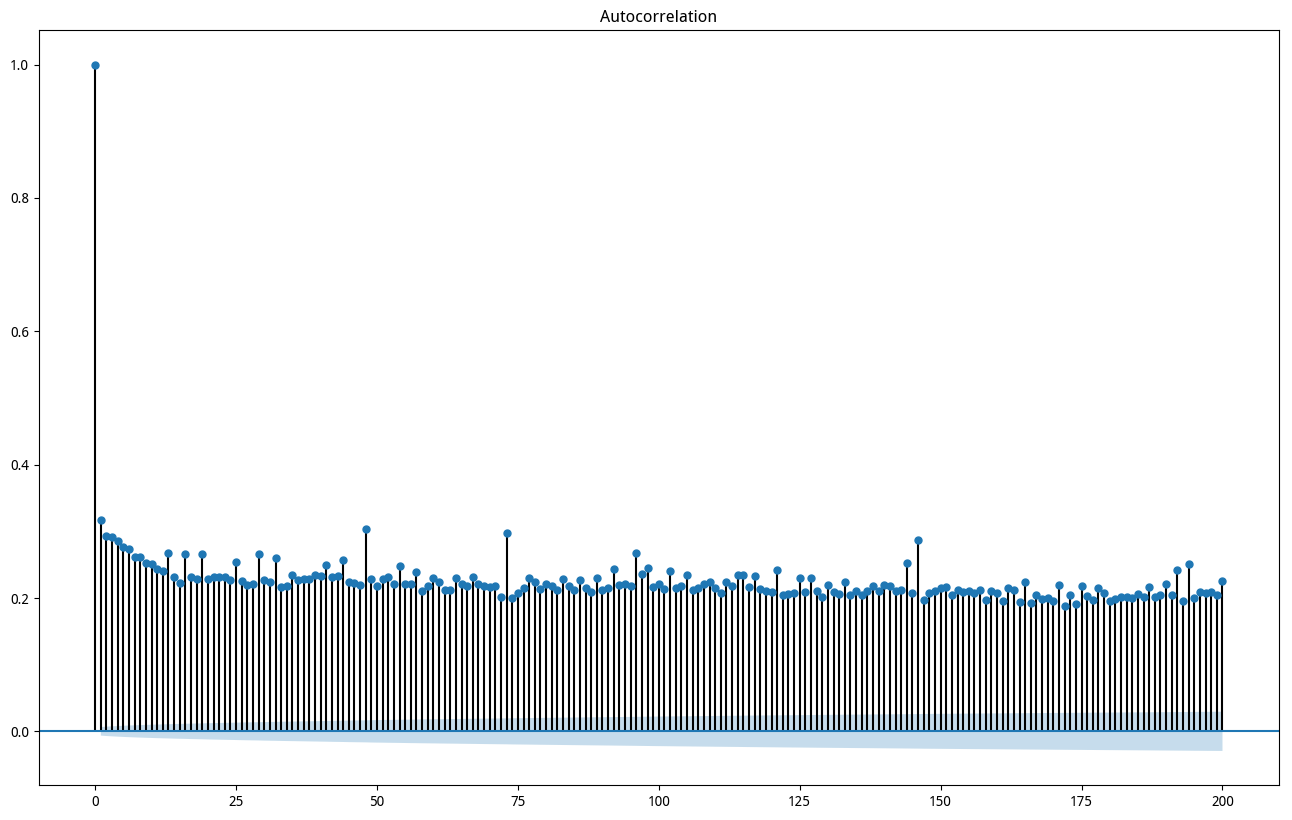

In [29]:
plot_acf(df_m5['range'], lags = 200)
plt.show()

range的实际空间也不大，超过20点的机会很小，考虑交易成本和保证金比例，利用range的策略应该不太好。

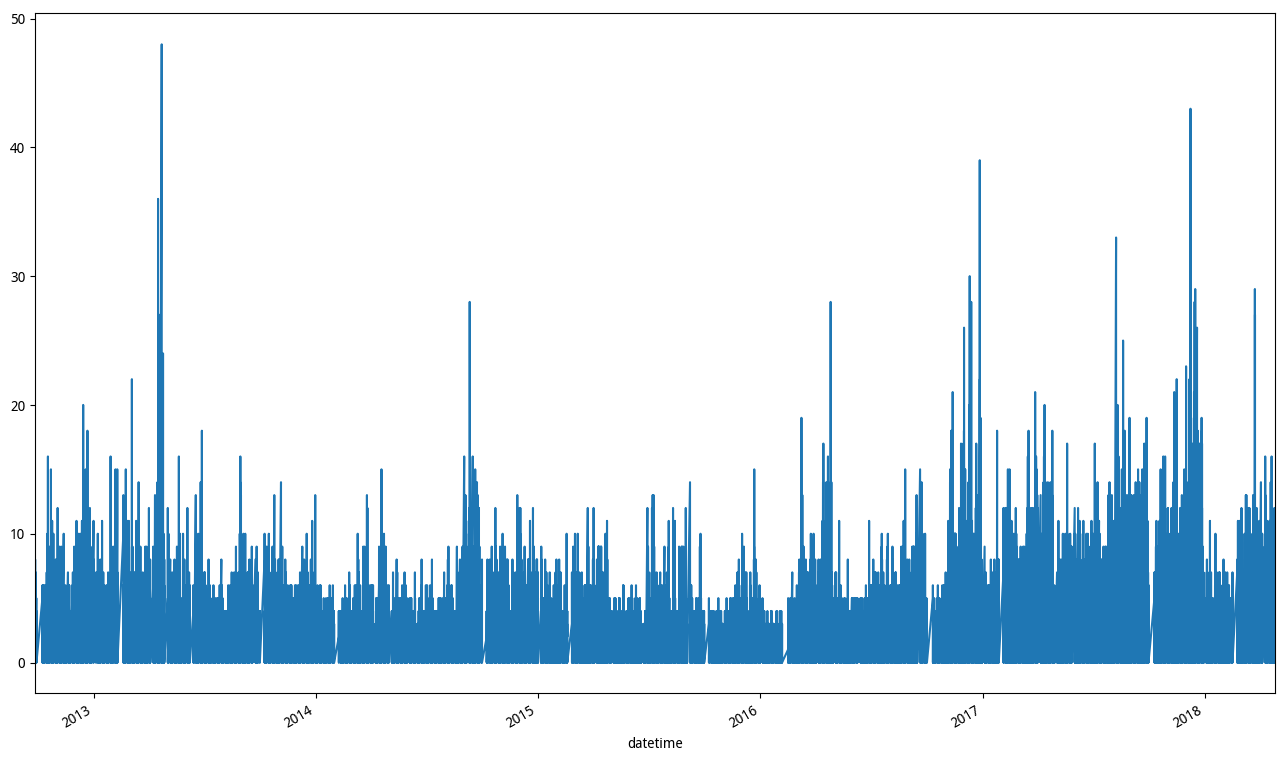

In [30]:
df_m5['range'].plot()
plt.show()

再来看看滚动的标准差，我们的策略思路就是价差超过一定标准差时进场，因此检验标准差很有必要。

通过目测和adf测试，初步来看，std的时间序列的平稳性非常好。

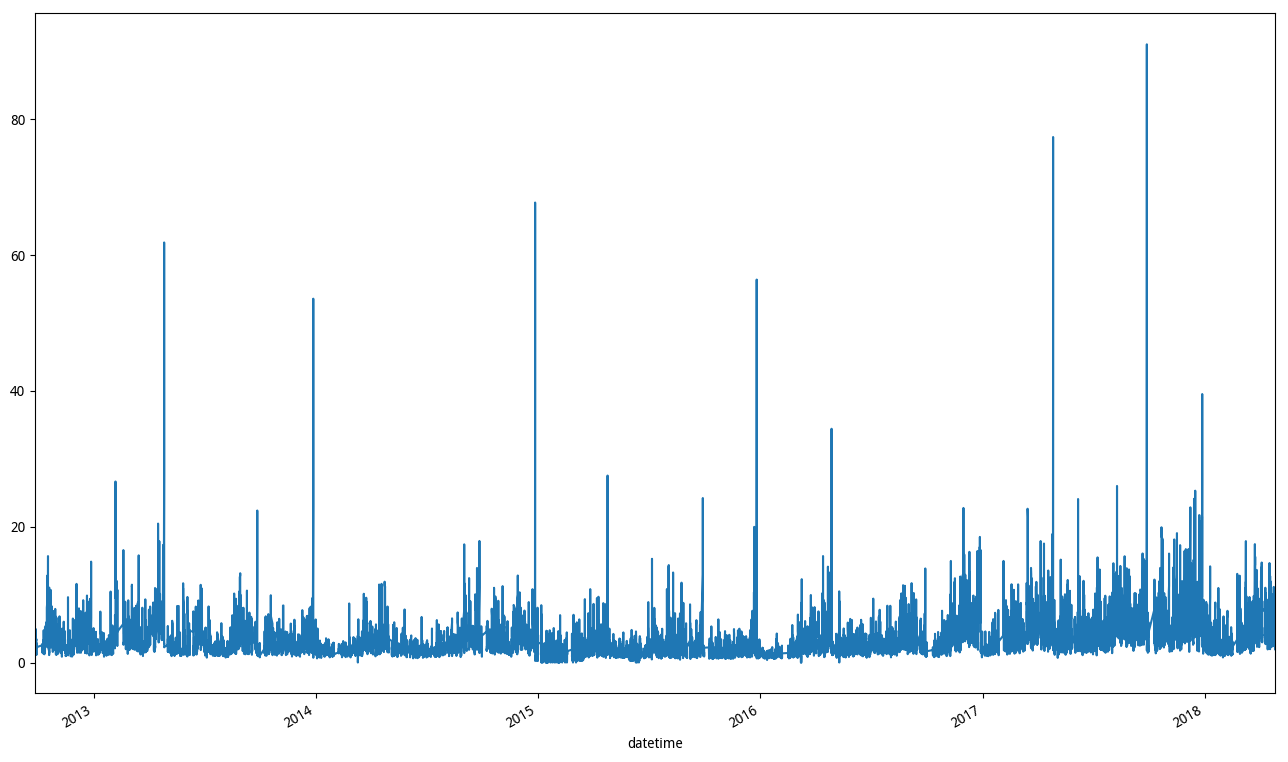

In [31]:
df_m5['std'].plot()
plt.show()

In [33]:
adfuller(df_m5['std'][20:])

(-19.865324982941811,
 0.0,
 64,
 93179,
 {'1%': -3.4304201819096258,
  '10%': -2.5667865104813989,
  '5%': -2.861571019279495},
 90982.020520535851)

std的自相关性也是比较平稳，不过波峰并不算太明显。

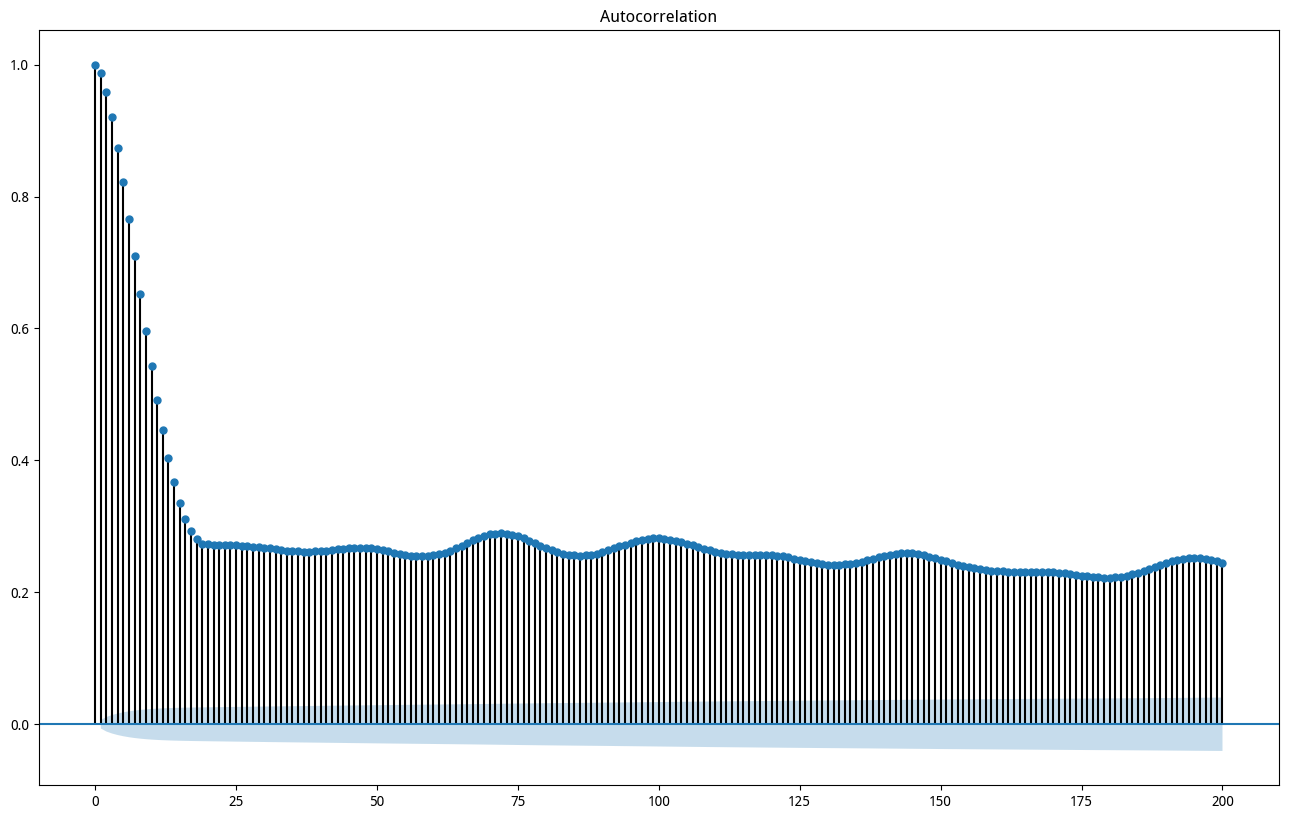

In [34]:
plot_acf(df_m5['std'][20:], lags = 200)
plt.show()

再来看看分布情况

std本身是一个尖峰的偏态分布，其对数是一个近似T分布

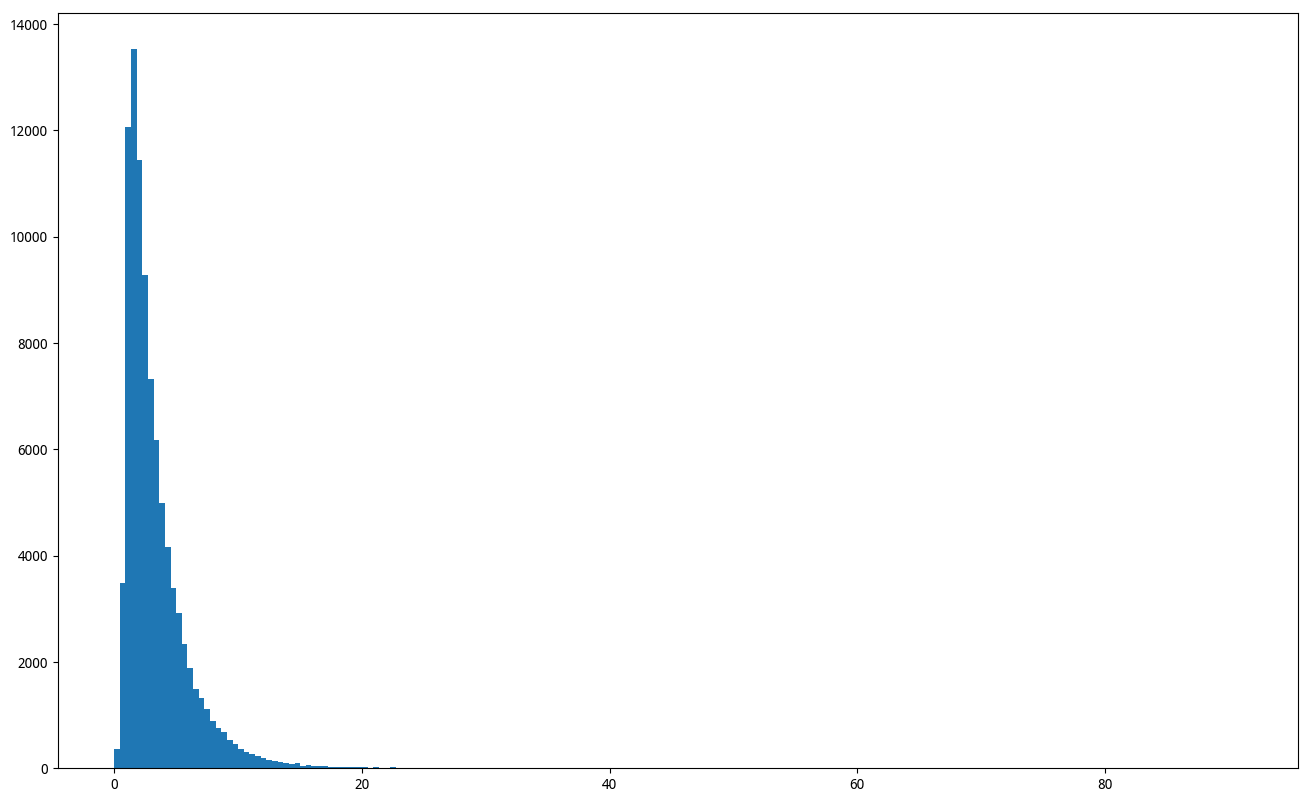

In [35]:
plt.hist(df_m5['std'][20:], bins = 200)
plt.show()

mean:0.4243679587767901
median:0.40548746604952557


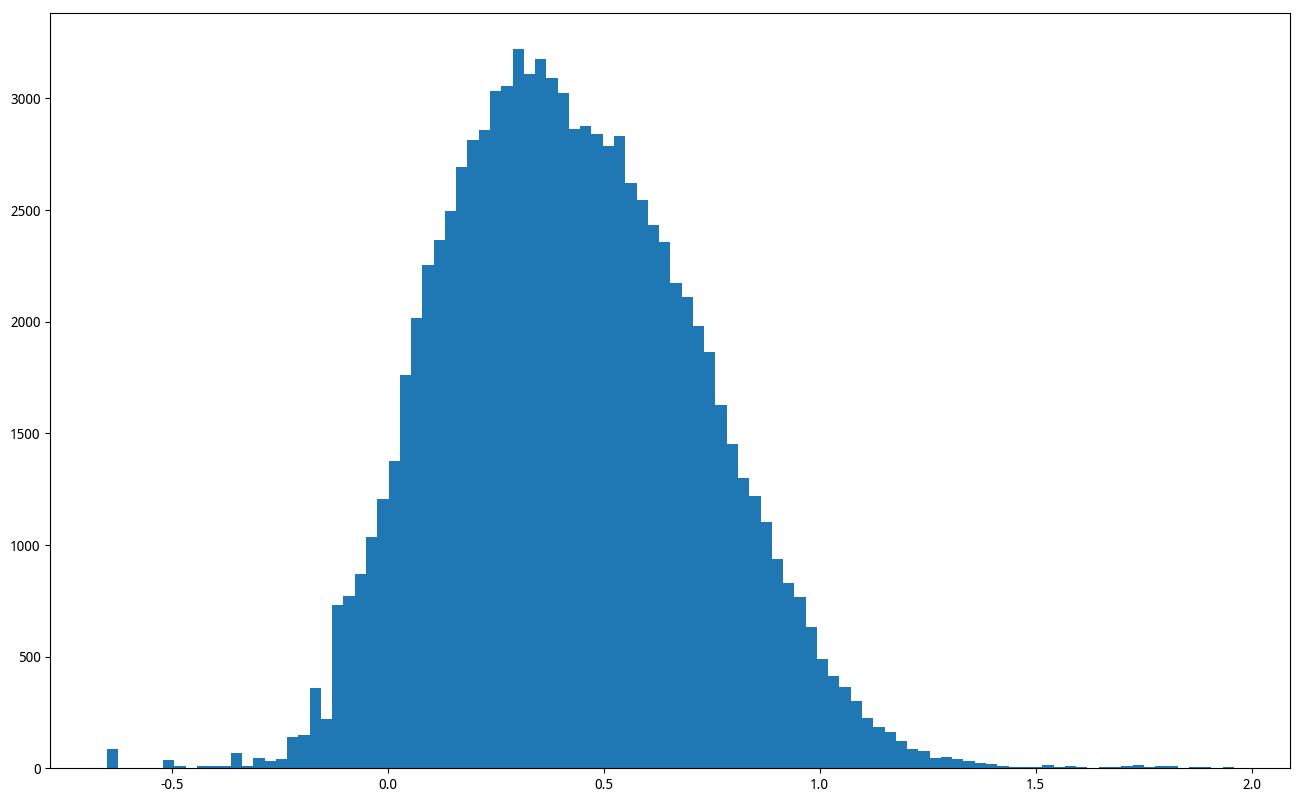

In [36]:
ln = []
l = df_m5['std'][20:].tolist()
for i in l:
    if i > 0.0001:
        ln.append(np.log10(i))
print('mean:{}'.format(np.mean(ln)))
print('median:{}'.format(np.median(ln)))
plt.hist(ln, bins = 100)
plt.show()

5分钟的残差（即close到ma的距离）和std的图

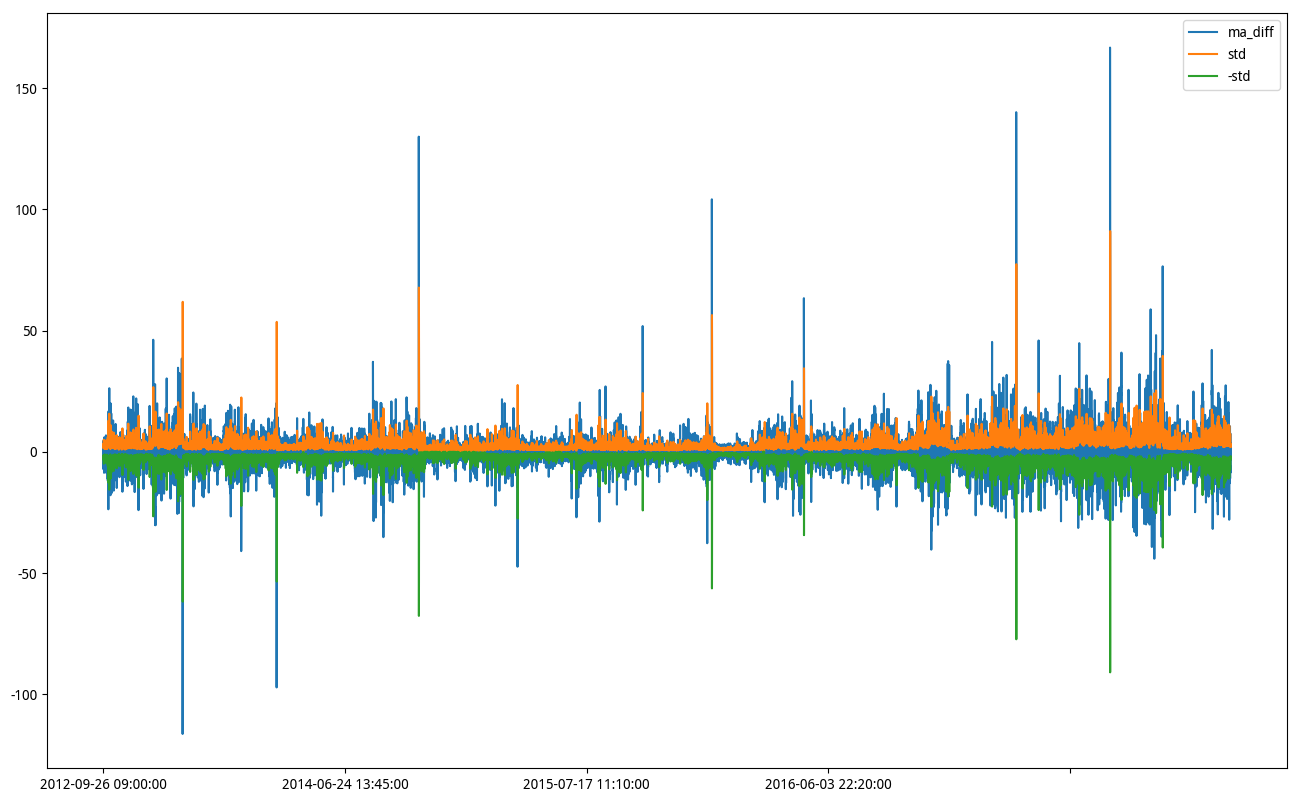

In [37]:
display1(df_m5, ['ma_diff','std', '-std'])

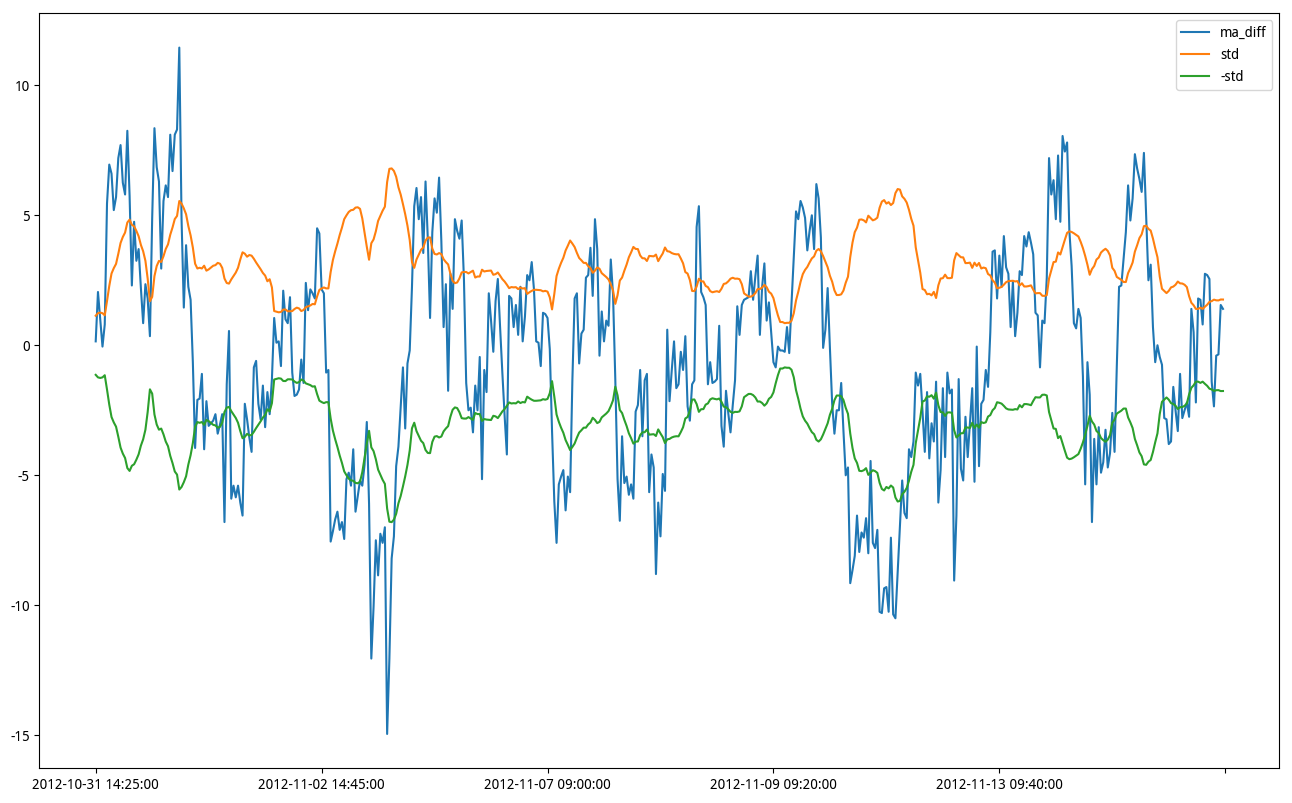

In [38]:
display1(df_m5[1000:1500], ['ma_diff','std', '-std'])

用残差偏离标准差的z值来看会更直观

In [51]:
df_m5['zscore'] = df_m5['ma_diff'] / df_m5['std']

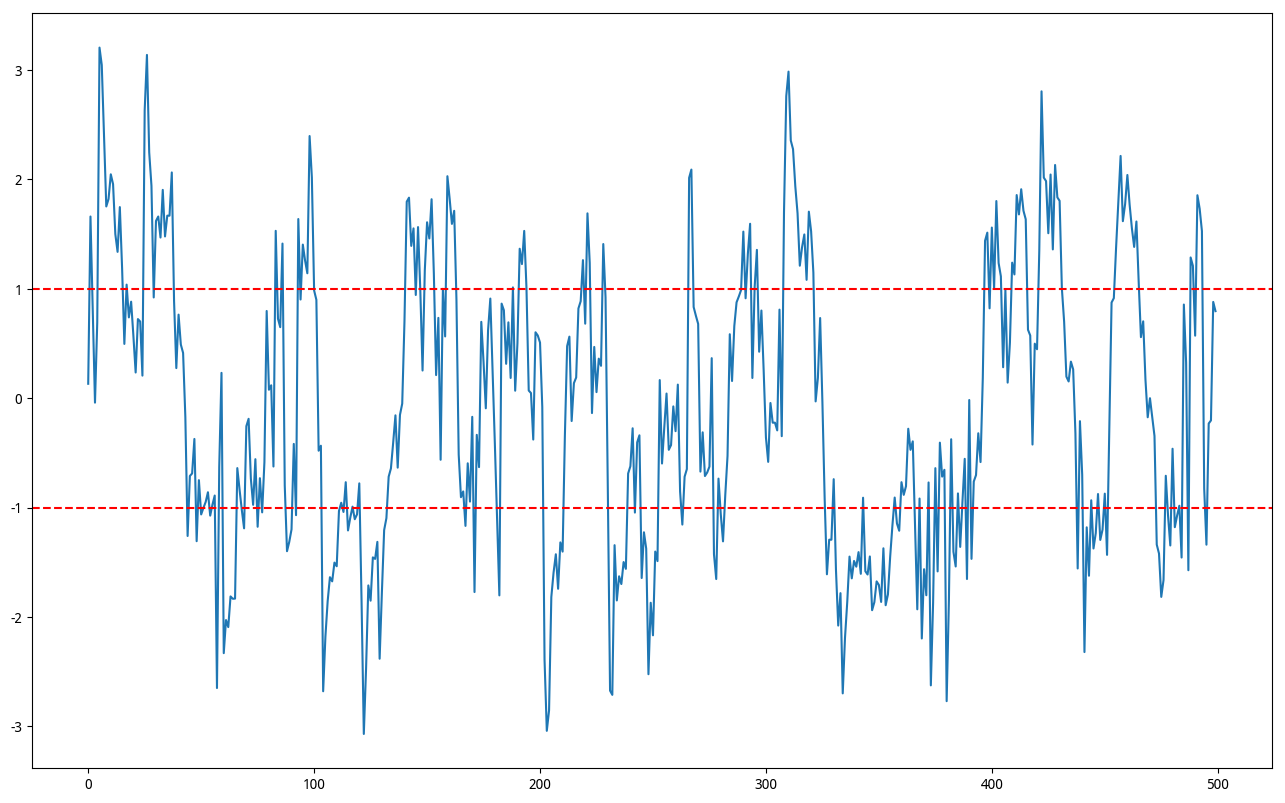

In [57]:
plt.plot(df_m5['zscore'][1000:1500].tolist())
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="red", linestyle="--")
plt.show()

5分钟的套利空间还是很客观的，在残差超过std进场的话，交易机会不少。

如果想缩减交易次数，就要把std过滤放大倍数了。

因此在回测中，std是必须进行测试和训练的参数，另一个参数则是std和ma的回顾时间窗口

### 策略及参数优化

目前，我们的策略框架是取leg1-leg2的价差，在5分钟周期上如果价差超过n2倍数的标准差，则在回落至n1倍数标准差时开仓，回到ma则平仓。

需要优化的参数则是均线、标准差的回顾周期lookback和标准差倍数n1、n2。

参数不宜过多，否则策略对参数过于敏感，robust和泛化能力就很差，一旦市场环境有变，就很容易失效了。

以做多为例，做空同理，每5分钟更新一次指标：

##### 价差：diff = leg1_5min_close - leg2_5min_close

##### 均价：ma = diff[-lookback:].mean

##### 标准差：std = diff[-lookback:].std

##### 第一下轨：lower1 = ma - n1 * std

##### 第二下轨：lower2 = ma - n2 * std  

##### 买入条件：价格下穿第二下轨后条件成立（True： price <= lower2） 直到价格回到中轨（False：until price >= ma）

##### 买入时机：价格上穿第一下轨（last_h < lower1 and current_h >= lower），buy leg1 and sell leg2

##### 卖出时机：价格上穿ma，sell leg1 and buy leg2

使用固定手数交易并且不添加加仓策略的话，可以不需要设固定止损，因为本身有涨跌停限制，但涨跌停以及流动性缺失带来的断腿风险也是需要考虑的。

因此需要加入了涨跌停不开仓的限制，以及断腿后的一般处理（对锁或平掉多余头寸）

参数调优范围理论上越大越好，但由于ricequant性能限制，这里用3 X 4 X 3的矩阵来进行回测。

lookback = [15, 20, 25], n1 = [1.5, 2, 2.5, 3], n2 = [n1 + 1, n1 + 1.5, n1 + 2]



以下为ricequant上的完整回测代码

``` python
import os
from rqalpha_plus import run_func
from rqalpha_plus.api import *

import pandas as pd
import numpy as np
import datetime

# 防止溢出
import sys
sys.setrecursionlimit(10**8) 
```

``` python
# 回测引擎配置，以2万做2*1手为例
config = {
  "base": {
    "start_date": "2015-05-04", #回测开始日期
    "end_date": "2017-04-28", #回测结束日期
    "frequency": '1m', #handle_bar周期
    "margin_multiplier": 1, #保证金倍率
    "accounts": {
        "future": 20000
    }
    
  },
  "extra": {
    "log_level": "info",
  },
  "mod": {
    "sys_progress": {
        "enabled": True,
        "show": True,
    },
    "sys_analyser": {
        "enabled": True,
    },
    "sys_simulation": {
    "matching_type": "current_bar", #当前bar收盘价交易
    "commission_multiplier": 1, #佣金倍率
    "slippage": 0, #滑点水平，ricequant的滑点按百分比计算，如有需要在回测后的total_value手动加上
    }
  }
}
```

``` python
# 形成参数矩阵，添加任务
tasks = []
# 用np.arange的格式显示会有问题
for bar_lookback in range(15, 26, 5): #3
    for n1_std in range(15, 31, 5): #4
        for n in range(10, 21, 5): #3
            tasks.append(( bar_lookback, n1_std/10, (n1_std + n)/10))
```

############################################################################

```python
# ricequant回测策略主体部分
def run_bt(config, bar_lookback, n1_std, n2_std):
    # 可以自己import我们平台支持的第三方python模块，比如pandas、numpy等。
    import datetime
    import pandas as pd
    import numpy as np

    # 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
    def init(context):
        # context内引入全局变量
        #context.benchmark = "RB88"
        # 注意回测开始日的主力合约
        context.leg1 = "RB1510"
        context.leg2 = "RB1601"
        context.pre_leg1 = "RB1505"
        context.pre_leg1_hold = False


        # 初始化时订阅合约行情。订阅之后的合约行情会在handle_bar中进行更新。
        subscribe(context.pre_leg1)
        subscribe(context.leg1)
        subscribe(context.leg2)
        # 实时打印日志
        logger.info("RunInfo: {}".format(context.run_info))

        # 今天涨停价，跌停价
        context.today_limit_up_leg1 = 0.0
        context.today_limit_down_leg1 = 0.0
        context.today_limit_up_leg2 = 0.0
        context.today_limit_down_leg2 = 0.0
        # 价格接近涨跌停价之间的距离，如果太过接近，则不开仓
        context.limitrange = 20.0

        # 当前bar信息和前一bar信息，用于处理买卖逻辑

        context.c_open_leg1 = 0.0
        context.c_high_leg1 = 0.0
        context.c_low_leg1 = 0.0
        context.c_close_leg1 = 0.0

        context.c_open_leg2 = 0.0
        context.c_high_leg2 = 0.0
        context.c_low_leg2 = 0.0
        context.c_close_leg2 = 0.0

        context.l_open_diff = 0.0
        context.l_high_diff = 0.0
        context.l_low_diff = 0.0 
        context.l_close_diff = 0.0
        context.c_open_diff = 0.0
        context.c_high_diff = 0.0
        context.c_low_diff = 0.0
        context.c_close_diff = 0.0

        # diff的指标
        context.diff = None
        context.ma = 0.0
        context.std = 0.0
        context.upper1 = 0.0
        context.upper2 = 0.0
        context.lower1 = 0.0
        context.lower2 = 0.0

        # 是否发出了报单指令
        context.fired_long = False
        context.fired_short = False

        # 条件
        context.condition_long = False
        context.condition_short = False

        # 开仓的手数
        context.lots_open_long = 1
        context.lots_open_short = 1
        # 持仓的手数
        context.hold_long_lots = 0
        context.hold_short_lots = 0

        # 指标的参数，可调参
        context.bar_lookback = bar_lookback
        context.n1_std = n1_std
        context.n2_std = n2_std

        # 跨期合约对
        context.pair_contracts = {
            '20130426': ('RB1310','RB1401'),
            '20130926': ('RB1401','RB1405'),
            '20131227': ('RB1405','RB1410'),
            '20140425': ('RB1410','RB1501'),
            '20140926': ('RB1501','RB1505'),
            '20141225': ('RB1505','RB1510'),
            '20150424': ('RB1510','RB1601'),
            '20150923': ('RB1601','RB1605'),
            '20151224': ('RB1605','RB1610'),
            '20160427': ('RB1610','RB1701'),
            '20160928': ('RB1701','RB1705'),
            '20161228': ('RB1705','RB1710'),
            '20170426': ('RB1710','RB1801'),
            '20170926': ('RB1801','RB1805'),
            '20171227': ('RB1805','RB1810'),
            '20180426': ('RB1810','RB1901')
        }

    # before_trading此函数会在每天策略交易开始前被调用，当天只会被调用一次
    def before_trading(context):

        date = context.now.date().strftime('%Y%m%d')
        for d in context.pair_contracts:
            # 重新订阅合约
            if date == d:
                unsubscribe(context.pre_leg1)
                unsubscribe(context.leg1)
                unsubscribe(context.leg2)
                context.pre_leg1,  context.leg1, context.leg2 = context.leg1, context.leg2, context.pair_contracts[d][1]
                subscribe(context.pre_leg1)
                subscribe(context.leg1)
                subscribe(context.leg2)
                logger.info(u'重新订阅pre_leg1:{},leg1:{},leg2:{}'.format(context.pre_leg1, context.leg1, context.leg2))

        if  context.future_account.positions[context.pre_leg1].buy_quantity or \
            context.future_account.positions[context.pre_leg1].sell_quantity:
            context.pre_leg1_hold = True
        else:
            context.pre_leg1_hold = False


    # 你选择的期货数据更新将会触发此段逻辑，例如日线或分钟线更新
    def handle_bar(context, bar_dict):
        # 当前bar时间
        now = context.now.time()

        # 计算两腿的ohlc
        current_bar_leg1 = bar_dict[context.leg1]
        context.c_open_leg1 = current_bar_leg1.open
        context.c_high_leg1 = current_bar_leg1.high
        context.c_low_leg1 = current_bar_leg1.low
        context.c_close_leg1 = current_bar_leg1.close

        current_bar_leg2 = bar_dict[context.leg2]
        context.c_open_leg2 = current_bar_leg2.open
        context.c_high_leg2 = current_bar_leg2.high
        context.c_low_leg2 = current_bar_leg2.low
        context.c_close_leg2 = current_bar_leg2.close    

        # 计算合成diff后的ohlc
        context.l_open_diff, context.l_high_diff = context.c_open_diff, context.c_high_diff
        context.l_low_diff, context.l_close_diff = context.c_low_diff, context.c_close_diff

        context.c_open_diff = context.c_open_leg1 - context.c_open_leg2
        context.c_high_diff = context.c_high_leg1 - context.c_high_leg2
        context.c_low_diff = context.c_low_leg1 - context.c_low_leg2
        context.c_close_diff = context.c_close_leg1 - context.c_close_leg2
        #############################################################################
        # 换合约对后，如之前的leg1有持仓则平仓，之前的leg2现在已变成leg1，可以在下方检查
        if context.pre_leg1_hold:
            buy_lots = context.future_account.positions[context.pre_leg1].buy_quantity
            sell_lots = context.future_account.positions[context.pre_leg1].sell_quantity
            if buy_lots:
                logger.info(u'之前的leg1：{}有未平仓合约，多头：{}'.format(context.pre_leg1, buy_lots))
                sell_close(id_or_ins = context.pre_leg1, amount = buy_lots)
            if sell_lots:
                logger.info(u'之前的leg1：{}有未平仓合约，空头：{}'.format(context.pre_leg1, sell_lots))
                buy_close(id_or_ins = context.pre_leg1, amount = sell_lots)
        #############################################################################
        # 检查两腿是否有持仓
        lots_long_leg1 = context.future_account.positions[context.leg1].buy_quantity
        lots_short_leg1 = context.future_account.positions[context.leg1].sell_quantity

        lots_long_leg2 = context.future_account.positions[context.leg2].buy_quantity
        lots_short_leg2 = context.future_account.positions[context.leg2].sell_quantity
        #############################################################################
        # 检查两腿是否同时进场了，如果没有，则直接平仓
        # 因为很可能是涨跌停因素导致某一腿没进场，所以等待下一次开盘全部平仓后再reset
        if lots_long_leg1 == lots_short_leg2:
            context.hold_long_lots = lots_long_leg1
        else:
            context.hold_long_lots = 0
            logger.info(u'多头持仓断腿，{}:{},{}:{}'.format(context.leg1, lots_long_leg1, context.leg2, lots_short_leg2))
            if lots_long_leg1:
                sell_close(id_or_ins = context.leg1, amount = lots_long_leg1)
            if lots_short_leg2:
                buy_close(id_or_ins = context.leg2, amount = lots_short_leg2)

        if lots_short_leg1 == lots_long_leg2:
            context.hold_short_lots = lots_short_leg1
        else:
            context.hold_short_lots = 0
            logger.info(u'空头持仓断腿，{}:{},{}:{}'.format(context.leg1, lots_short_leg1, context.leg2, lots_long_leg2))  
            if lots_short_leg1:
                buy_close(id_or_ins = context.leg1, amount = lots_short_leg1)
            if lots_long_leg2:
                sell_close(id_or_ins = context.leg2, amount = lots_long_leg2)
        #############################################################################   
        # 早午晚盘开盘前的处理
        if (now == datetime.time(9,1,0,0)) or (now == datetime.time(13,31,0,0)) or (now == datetime.time(21,1,0,0)):
            # 获取涨停价，跌停价
            df1 = history_bars(order_book_id = context.leg1, bar_count = 1, 
                            frequency = '1d', fields = ['limit_up', 'limit_down'], include_now = True)
            context.today_limit_up_leg1, context.today_limit_down_leg1 = df1[0]

            df2 = history_bars(order_book_id = context.leg2, bar_count = 1, 
                            frequency = '1d', fields = ['limit_up', 'limit_down'], include_now = True)
            context.today_limit_up_leg2, context.today_limit_down_leg2 = df2[0]

            # 初始化
            if context.hold_long_lots == 0:
                context.fired_long = False
            if context.hold_short_lots == 0:
                context.fired_short = False
        #############################################################################
        # 如果leg1接近跌停价或leg2接近涨停价，不开多头，直到开盘reset
        if (context.c_low_leg1 <= context.today_limit_down_leg1 + context.limitrange) or \
           (context.c_high_leg2 >= context.today_limit_up_leg2 - context.limitrange) :
            context.fired_long = True
        # 如果leg1接近涨停价或leg2接近跌停价，不开空头，直到开盘reset
        if (context.c_high_leg1 >= context.today_limit_up_leg1 - context.limitrange) or \
           (context.c_low_leg2 <= context.today_limit_down_leg2 + context.limitrange) :
            context.fired_long = True    

        #############################################################################
        # 每5分钟更新一次指标
        if ((now.minute - 1) % 5) == 0:
            close_leg1 = history_bars(order_book_id = context.leg1, bar_count = context.bar_lookback, 
                            frequency = '5m', fields = 'close', include_now = False)
            close_leg2 = history_bars(order_book_id = context.leg2, bar_count = context.bar_lookback, 
                            frequency = '5m', fields = 'close', include_now = False)    

            df = pd.DataFrame({'leg1':close_leg1, 'leg2':close_leg2})
            df['diff'] = df['leg1'] - df['leg2']
            context.diff = df['diff']
            context.ma = context.diff.mean()
            context.std = context.diff.std()
            context.upper1 = context.ma + context.n1_std * context.std
            context.upper2 = context.ma + context.n2_std * context.std
            context.lower1 = context.ma - context.n1_std * context.std
            context.lower2 = context.ma - context.n2_std * context.std     
        #############################################################################
        # 如果价格曾低于lower2，则符合买入条件
        if context.c_low_diff <= context.lower2:
            context.condition_long = True
        # 条件直到回到中轨，则reset    
        if context.c_high_diff >= context.ma:    
            context.condition_long = False

        if context.c_high_diff >= context.upper2:
            context.condition_short = True
        if context.c_low_diff <= context.ma:    
            context.condition_short = False    
        #############################################################################
        # 星期五收盘清理所有持仓
        if (context.now.strftime('%w') == '5' and ((now == datetime.time(14,59,0)) or (now == datetime.time(22,59,0)))):
            # 限价单报单撤销
            #if get_open_orders() != []:
            #    for order in get_open_orders():
            #        cancel_order(order)
            # 如手数不为1，可能会有未成交的平仓单，需要重新获取
            # 如long_lots = context.future_account.positions[context.s].closable_buy_quantity
            # 收盘前市价平仓
            context.fired_long = True
            context.fired_short = True
            if context.hold_long_lots != 0:
                sell_close(id_or_ins = context.leg1, amount = context.hold_long_lots)
                buy_close(id_or_ins = context.leg2, amount = context.hold_long_lots)
            if context.hold_short_lots != 0:
                buy_close(id_or_ins = context.leg1, amount = context.hold_short_lots)
                sell_close(id_or_ins = context.leg2, amount = context.hold_short_lots)
        ############################################################################# 
        # 换合约对的前一日，不开仓，保证全部平仓，简化换合约对后对持仓的处理
        if (context.now.date() + datetime.timedelta(days = 1)).strftime('%Y%m%d') in context.pair_contracts:
            context.fired_long = True
            context.fired_short = True

            if lots_long_leg1:
                sell_close(id_or_ins = context.leg1, amount = lots_long_leg1)
            if lots_long_leg2:
                buy_close(id_or_ins = context.leg2, amount = lots_long_leg2)        

            if lots_short_leg1:
                buy_close(id_or_ins = context.leg1, amount = lots_short_leg1)
            if lots_short_leg2:
                sell_close(id_or_ins = context.leg2, amount = lots_short_leg2)  
        #############################################################################
        # 开仓逻辑，曾下破lower2且上穿lower1时，做多diff，曾上破upper2且下穿upper1时，做空diff
        # 早午晚盘最后一分钟不发单
        if not (now == datetime.time(11,30,0) or now == datetime.time(15,0,0) or now == datetime.time(23,0,0)):
            if not context.pre_leg1_hold:
                # 多头
                if not context.fired_long and context.condition_long and context.hold_long_lots == 0:
                    # 从下向上穿过lower1
                    if context.l_high_diff < context.lower1 and context.c_high_diff >= context.lower1:
                        buy_open(id_or_ins = context.leg1, amount = context.lots_open_long)
                        sell_open(id_or_ins = context.leg2, amount = context.lots_open_long)
                        context.fired_long = True
                # 空头
                if not context.fired_short and context.condition_short and context.hold_short_lots == 0:
                    if context.l_low_diff > context.upper1 and context.c_low_diff <= context.upper1:
                        sell_open(id_or_ins = context.leg1, amount = context.lots_open_short)
                        buy_open(id_or_ins = context.leg2, amount = context.lots_open_short)
                        context.fired_short = True     

        #############################################################################
        # 平仓逻辑，回到中轨ma
        # 多头
        if context.hold_long_lots > 0:
            if context.c_high_diff >= context.ma:
                sell_close(id_or_ins = context.leg1, amount = context.hold_long_lots)
                buy_close(id_or_ins = context.leg2, amount = context.hold_long_lots)
                # reset条件
                context.fired_long = False
        # 空头
        if context.hold_short_lots > 0:
            if context.c_low_diff <= context.ma:
                buy_close(id_or_ins = context.leg1, amount = context.hold_short_lots)
                sell_close(id_or_ins = context.leg2, amount = context.hold_short_lots)
                context.fired_long = False    
        #############################################################################


    # after_trading函数会在每天交易结束后被调用，当天只会被调用一次
    def after_trading(context):
        pass
    
    result = run_func(init=init, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config)
    return result, bar_lookback, n1_std, n2_std
```

############################################################################

``` python
# 批量进行任务，获得回测结果
def run_tasks(tasks):
    import time
    time_start=time.time()
    results = []
    summaries = []
    i = 0
    for task in tasks:
        i += 1
        print('task {} running'.format(i))
        print('para: bar_lookback={}-n1_std={}-n2_std={}'.format(task[1], task[2], task[3]))
        result = run_bt(*task)
        
        #results.append({'bar_lookback={}-n1_std={}-n2_std={}'.format(result[1], result[2], result[3]) : result[0]})
        summaries.append({'_para_bar_lookback': result[1],
                          '_para_n1_std': result[2],
                          '_para_n2_std': result[3],
                          'total_value': result[0]['sys_analyser']['summary']['total_value'],
                          'sharpe': result[0]['sys_analyser']['summary']['sharpe'],
                          'max_drawdown': result[0]['sys_analyser']['summary']['max_drawdown'],
                          'volatility': result[0]['sys_analyser']['summary']['volatility'],
                          'downside_risk': result[0]['sys_analyser']['summary']['downside_risk'],
                          #'alpha': result[0]['sys_analyser']['summary']['alpha'],
                          #'beta': result[0]['sys_analyser']['summary']['beta'],
                          'sortino': result[0]['sys_analyser']['summary']['sortino'],
                          'annualized_returns': result[0]['sys_analyser']['summary']['annualized_returns'],
                          'information_ratio': result[0]['sys_analyser']['summary']['information_ratio'],
                          'unit_net_value': result[0]['sys_analyser']['summary']['unit_net_value'],
                          'tracking_error': result[0]['sys_analyser']['summary']['tracking_error'],
                          'trades': len(result[0]['sys_analyser']['trades'])
                         })
    time_end=time.time()
    print('{} tasks finished!'.format(i))
    print('time spent: {}'.format(time_end - time_start))
    return summaries
```

In [39]:
df_s = pd.read_csv('summary2.csv', index_col=0).sort_values(by='sharpe', ascending=False)

In [41]:
df_s

,_para_bar_lookback,_para_n1_std,_para_n2_std,annualized_returns,downside_risk,information_ratio,max_drawdown,sharpe,sortino,total_value,tracking_error,trades,unit_net_value,volatility
0,15,1.5,2.5,0.072,0.054,1.036,0.081,0.641,0.817,22958.268,0.069,6194,1.148,0.069
31,25,2.5,4.0,0.041,0.031,1.006,0.051,0.342,0.460,21683.589,0.041,966,1.084,0.041
18,20,2.5,3.5,0.040,0.038,0.823,0.075,0.259,0.334,21604.569,0.048,1870,1.080,0.048
19,20,2.5,4.0,0.037,0.029,0.934,0.044,0.253,0.346,21516.046,0.040,1214,1.076,0.040
32,25,2.5,4.5,0.035,0.029,0.920,0.053,0.205,0.274,21420.991,0.038,618,1.071,0.038
2,15,1.5,3.5,0.037,0.047,0.682,0.066,0.195,0.234,21519.180,0.056,2712,1.076,0.056
1,15,1.5,3.0,0.036,0.053,0.568,0.101,0.150,0.184,21446.502,0.065,4180,1.072,0.065
33,25,3.0,4.0,0.032,0.030,0.798,0.057,0.124,0.165,21296.821,0.040,782,1.065,0.040
17,20,2.0,4.0,0.030,0.032,0.708,0.043,0.074,0.098,21215.533,0.043,1318,1.061,0.043
30,25,2.5,3.5,0.030,0.042,0.569,0.087,0.068,0.088,21213.185,0.054,1626,1.061,0.054


回测结果的sharpe不算太好，套利策略的年回报率一般不会太高，要提高sharpe，一是提高杠杆率，其次是降低波动率。

其中一个原因可能是我们的参数范围并没有过滤掉极端行情。

另一个原因可能是我们的参数范围过于敏感，因此当波动性不足时就会频繁进场小亏损。

因此，要权衡好参数的设置是一个学问，这里如果能扫描更广的参数范围，可能会获得更好的结果。

看看其他有意思的地方，sharpe第一的参数设置较小，可以理解为频繁进场的策略，因此交易次数比sharpe第二的策略多5倍。

频繁刷单获得高收益是可以理解的，但需要较低的交易成本和少发生极端行情。

如果交易次数不多，本身套利的获利点数就比较小，因此盈利也一般不会太好。

对参数的选择需要考虑其他的绩效度量，可讨论的地方很多但也是最棘手的地方。

这里先选择sharpe最佳的参数作为验证样本里的参数选择好了，即回顾窗口15，标准差倍数1.5和2.5。

#### 接下来需要做统计上的假设检验，来验证策略的可靠性。

在上面的分析里，我们先验地认为策略的回报应该是与策略本身有关。

然而期货市场是一个信噪比极低的市场，因此我们的策略也只有一点点的预测能力。

而我们的样本量又不足，因此我们也很有可能是幸运地得到好的回报而已。

因此，在进行下一步之前，有必要对先前获得的样本进行一次显著性的假设检验。

假设策略里回报率的时间序列为R，策略发出信号的时间序列为S（非多即空的标准化指标也可以是指标本身数值），市场的噪音为$\nu$。

有R = $\lambda$S + $\nu$，其中$\nu$应该服从正态分布或T分布。

我们希望R和S的相关性是显著的，否则有R = $\nu$，即策略回报完全是由随机的噪音所造成。

下面进行单样本的假设检验：

零假设：corr(R, S) ~ 0

通过10000次蒙地卡罗模拟，得出R和$\nu$相关性的t分布。

如果corr(R, S)在p_value=0.05的置信区间外，则推翻零假设。

否则不能推翻零假设，我们认为S和噪音$\nu$无异。

In [42]:
df_tester = pd.read_csv('rbtester.csv',index_col=0)

In [43]:
df_tester['return'] = df_tester['value'].diff(1)/df_tester['value']
df_tester = df_tester[1:].copy()
len(df_tester)

39146

In [44]:
correlations = []
r = df_tester['return'].tolist()
for i in range(10000):
    n = np.random.normal(0,1,len(df_tester))
    df_sim = pd.DataFrame(data = {'return': r, 'noise': n})
    correlations.append(df_sim.corr('spearman').iloc[0,1])

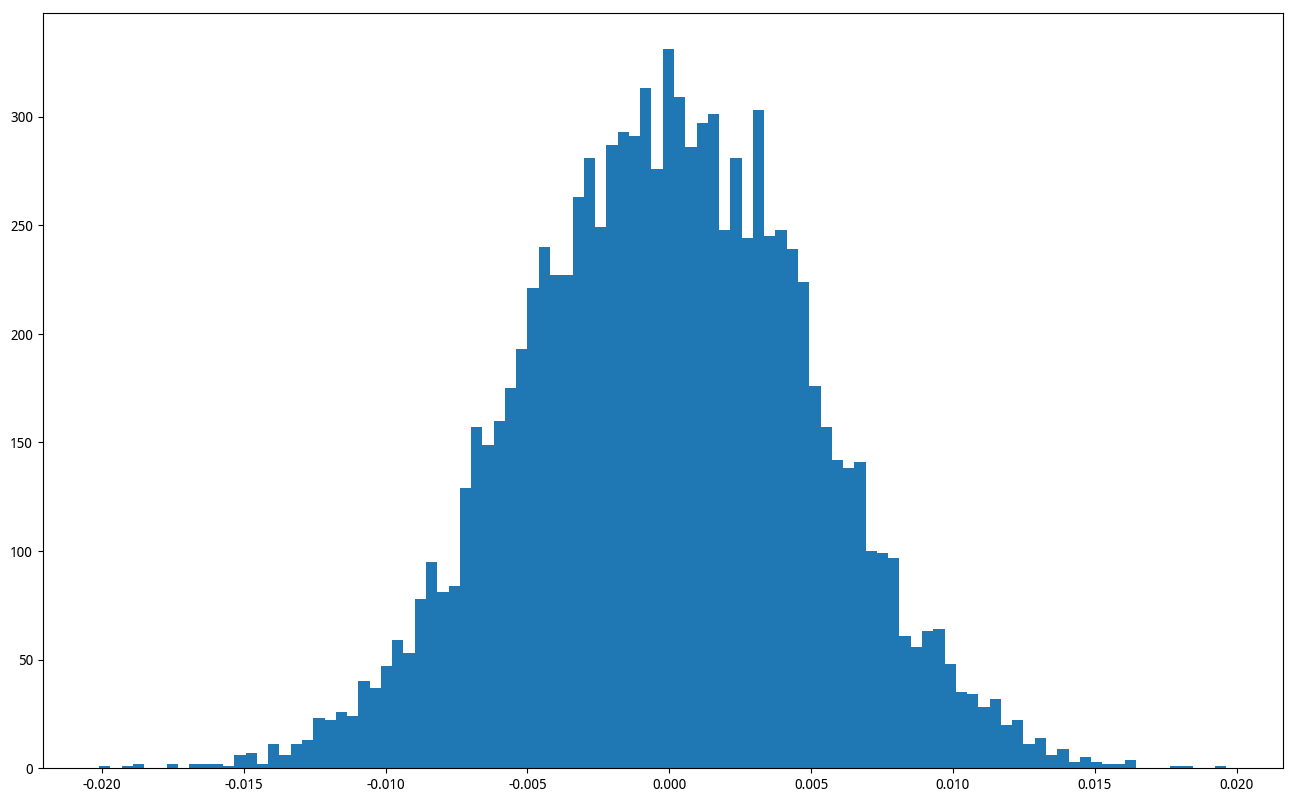

In [45]:
plt.hist(correlations, bins = 100)
plt.show()

In [46]:
df_corr = pd.DataFrame({'corr':correlations}).sort_values(by='corr')
df_corr.iloc[250,0],df_corr.iloc[9750,0]

(-0.010069570814155266, 0.0099542709096566082)

In [47]:
df_tester.corr('spearman').iloc[1:,1:]

,signal,return
signal,1.000000,-0.088003
return,-0.088003,1.000000


零假设的置信区间为(-0.001,0.001)

corr(R, S)落在置信区间外，因此我们拒绝零假设，我们认为策略发出的信号S与回报率R之间的相关性比较显著。

### 回测验证样本

下面看看ricequant上测试样本和验证样本的可视化报告

![](http://chuantu.biz/t6/318/1527097328x-1566688760.png)

![](http://chuantu.biz/t6/318/1527097073x-1566688760.png)

在验证样本里竟然获得了22%的年回报率和1.7的sharpe，表现超过了预期。

可以看到我们的策略在回测样本中有两次较大的回撤，其中还发生了一次较大的亏损，这次亏损是换约断腿导致头寸暴露。

至于回测的原因需要具体分析行情，原因可能是行情每次打了止损后又产生了进场机会，如果是单边行情，理应不会产生这么多次进场信号。

这也说明了我们的模型对过滤行情做得还不够好。

作为对比，来看看sharpe第二的参数配置即(25, 2.5, 4.0)在回测样本中的结果。

![](http://chuantu.biz/t6/318/1527098488x-1566688760.png)

这个参数配置会过滤较多行情，因此交易机会较少，不过各项绩效度量都保持了与在回测样本中的相对一致。

第一种参数配置表现不太稳定，因此怀疑可能有过拟合的嫌疑，或者超常发挥，再看看其5年的表现。

![](http://chuantu.biz/t6/318/1527099028x-1566688760.png)

除了两次回撤外，其他时间的回报率增长很平稳，除了最后一年外每年的年回报率在7~10%之间，相对稳定，可以说最近一年是超常发挥。

如果能继续改进，过滤掉这两次回撤的行情，考虑到以之前的保证金比例还可以加大杠杆，这会是一个不错的策略。

### 总结与展望

量化研究需要做的工作很多，本报告只是提供了其中一小部分工作的个人见解，作为量化领域的初学者，不足之处敬请多多批评。

后面需要完善的工作很多，横向需要做的是对多合约对（国外市场更低保证金比例和更长的交易时间等较合理的交易规则对套利相比国内市场友好）、多周期（不过太大周期可能会因为统计样本较小而降低策略表现）、多策略（如以残差代替价差作为交易对象）的研究。

纵向需要完善撮合逻辑、断腿后的风险处理等，以使回测环境和模拟环境尽量贴近实盘。此外，也可以增加网格类报单策略，可以平滑回报率曲线，不过以国内期货市场目前较高的保证金比例和交易费用来看，可能难以显著提高回报表现。

总的来说，为了提高研究效率，搭建线下的高效研究平台是很有必要的，第三方平台毕竟性能有限。